# [Exp11]GenerateCIFAR-10

## 라이브러리

### 라이브러리 확인

In [1]:
import tensorflow as tf
import imageio

print(tf.__version__)
print(imageio.__version__)

2.8.2
2.9.0


### 라이브러리 불러오기

In [2]:
import os
import glob
import time
import PIL
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 작업환경 구성

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# ! mkdir /content/drive/MyDrive/Exploration/11_Submit/generated_samples
# ! mkdir /content/drive/MyDrive/Exploration/11_Submit/training_checkpoints
# ! mkdir /content/drive/MyDrive/Exploration/11_Submit/training_history

## 데이터셋 구성

### 데이터 불러오기

In [5]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
print(train_x.shape)
print(test_x.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### -1,1 정규화

In [6]:
print(train_x[0][0][0])
train_x = (train_x - 127.5) / 127.5
print(train_x.shape)
print(train_x[0][0][0])

[59 62 63]
(50000, 32, 32, 3)
[-0.5372549  -0.51372549 -0.50588235]


### 데이터 시각화

* row와 col에 맞춰서 이미지를 출력

In [7]:
def show_image(row = 2, col = 5, img_list = train_x):
    total = row * col
    rand_idx = []
    fig, axes = plt.subplots(row, col, figsize = (col*5,row*5))
    axes = axes.flatten()

    for i in range(total):
        rand_idx.append(np.random.randint(0,50000))

    for idx, value in enumerate(rand_idx):
        # pic = axes[idx].imshow(img_list[value],cmap = 'viridis')
        pic = axes[idx].imshow((img_list[value] + 1)/2)
        axes[idx].set_title('Index' + str(value))
        axes[idx].axis('off')
        # fig.colorbar(pic, ax = axes[idx])

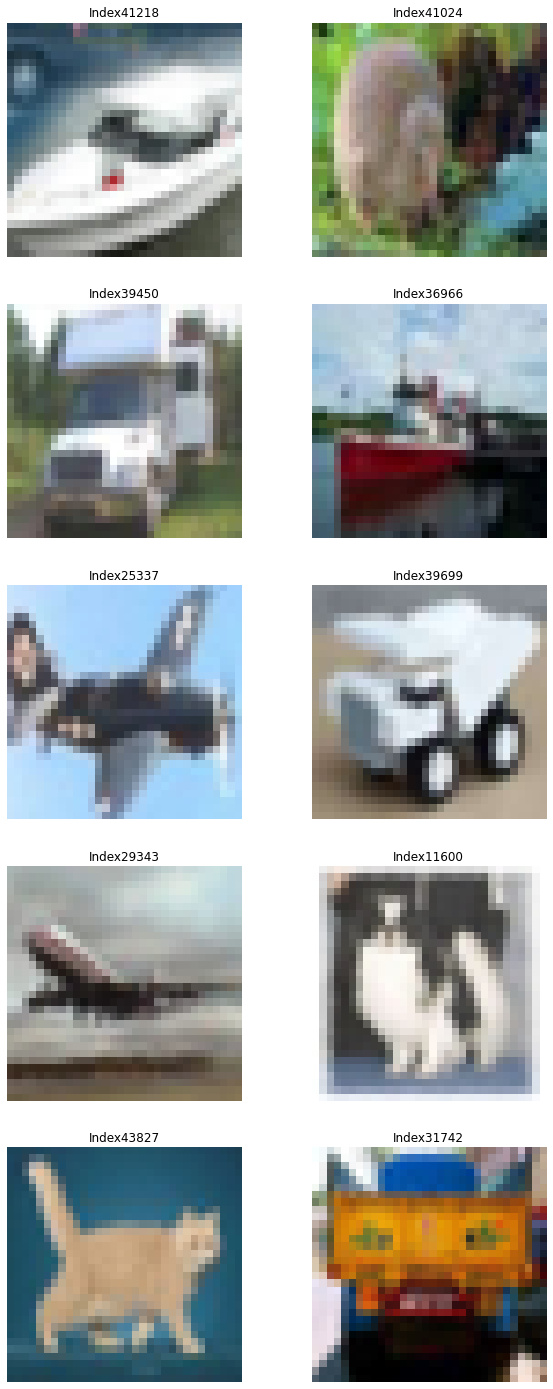

In [8]:
show_image(5,2)

### mini batch dataset 구성

* 50000 + 10000 = 60000

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 모델 구현하기

### Generator

* 최종이 (32, 32, 3)에 맞춰질 수 있게 초기를 (8, 8)에 맞춥니다.
* (8, 8) = (16, 16) = (32, 32)
* 마지막 값은 rgb 값으로 3을 넣어줍니다. 

In [10]:
def make_generator_model():

    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

### Noise vector

* noise 를 넣어서 생성자로 이미지 하나를 만들어보고 shape를 확인합니다.
* (32,32,3)으로 나옵니다.

In [12]:
noise = tf.random.normal([1, 100])

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

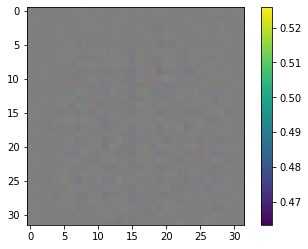

In [14]:
generated_image_color = (generated_image + 1)/2
plt.imshow(generated_image_color[0, :, :, :])
plt.colorbar()
plt.show()

## 판별자 모델 구현

* input shape는 (32,32,3)로 하고 최종 값은 T/F 중 하나이므로 1입니다.

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

### 결과값 확인

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00603802]], dtype=float32)>

## 손실 함수, 최적화 함수

* 손실 함수

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

* 최적화 함수

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

* 16 x 100 noise vector

In [21]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련 기능 상세 구현

### mini batch 훈련 과정 처리

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

* predictions의 모든 parts(마지막의 색부분 까지)를 사용합니다.
* 계산 시간을 위해 이미지 출력은 생략하겠습니다.

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    predictions_color = (predictions + 1) /2
    fig = plt.figure(figsize=(12, 12))
    for i in range(predictions_color.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions_color[i, :, :, :])
        plt.axis('off')
        
    plt.savefig('/content/drive/MyDrive/Exploration/11_Submit/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    plt.savefig('/content/drive/MyDrive/Exploration/11_Submit/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

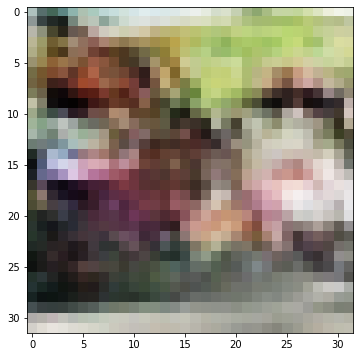

In [25]:
checkpoint_dir = '/content/drive/MyDrive/Exploration/11_Submit/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

## 모델 학습

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 50
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

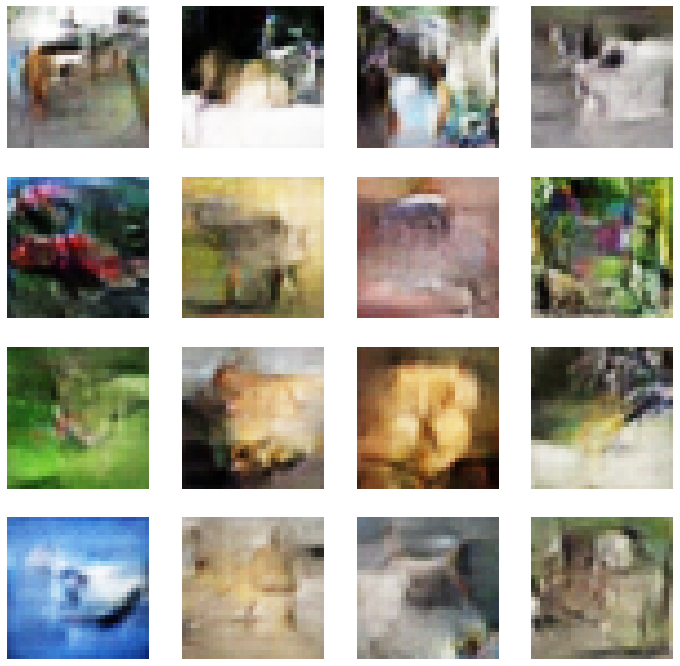

Time for training : 513 sec


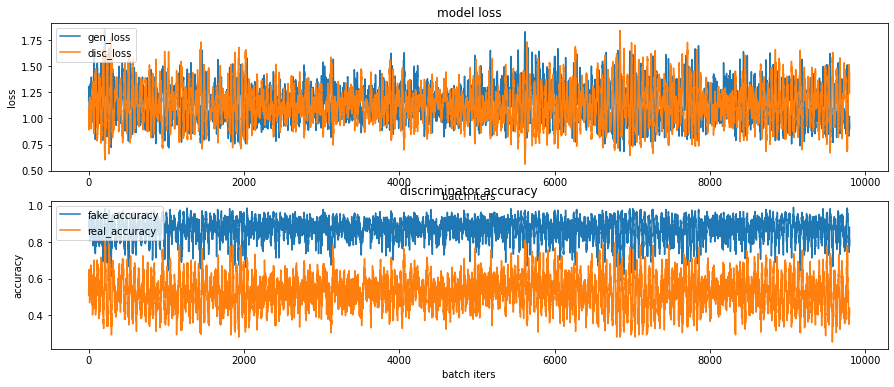

CPU times: user 8min 47s, sys: 10.6 s, total: 8min 58s
Wall time: 8min 35s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

### 학습과정 시각화

In [34]:
anim_file = '/content/drive/MyDrive/Exploration/11_Submit/generated_samples_50.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Exploration/11_Submit/generated_samples_50/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<img src = 'https://drive.google.com/uc?id=19XpaW4Gn9I4P1HbF55CMzef1xUwmbxYW'
height = 400 width = 400 >

## GAN 훈련 과정 개선하기

### How to Train a GAN? Tips and tricks to make GANs work

* epoch를 100으로 늘립니다.

In [36]:
EPOCHS = 100

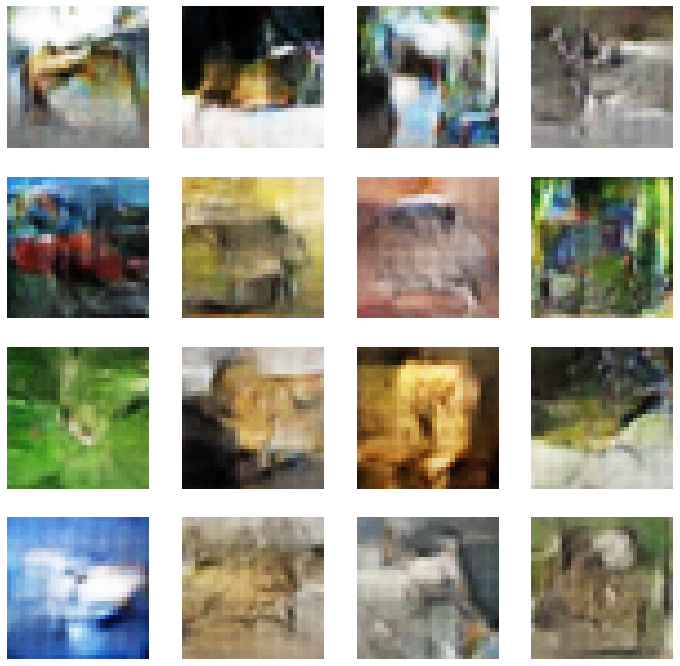

Time for training : 1038 sec


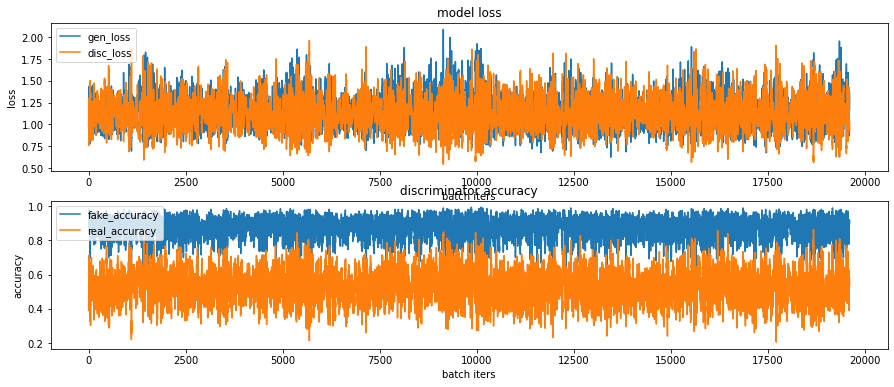

CPU times: user 17min 51s, sys: 18.8 s, total: 18min 10s
Wall time: 17min 20s


In [37]:
%%time
train(train_dataset, EPOCHS, save_every)

* 시각화

In [38]:
anim_file = '/content/drive/MyDrive/Exploration/11_Submit/generated_samples_100.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Exploration/11_Submit/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<img src = 'https://drive.google.com/uc?id=1Rc_cLZShjzly2W8AxW0KqTNJtnKmLgny'
height = 400 width = 400 >

* epoch를 증가시켜서 비교를 해보겠습니다.
 - epoch 50, 100 둘 다 뭔가 cifar-10의 이미지처럼 보였습니다.
 - epoch가 50일때 보다 100일때 이미지가 조금 더 선명해보였습니다.
 - gif로만 비교해서는 색 변화 정도가 조금 다른 것 말고는 큰 차이를 느끼지 못했습니다.
 - accuray와 loss 그래프는 epoch가 50일때 보다 epoch가 100일 때 더 뚜거운 형태로 이루어져 있습니다.


## 회고

* 이번 프로젝트에서 어려웠던 점
    - fake accuracy를 확실히 낮추는게 어려웠다.
    - 프로젝트 제출 페이지에 있던 링크에 있던 내용들이 이해하기 어렵습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된 점
    - 다중 array의 데이터의 형태와 broadcast를 통한 데이터 변경
    - rgb가 -1 ~ 1의 범위면 -1 ~ 0 은 검은색으로 만듭니다.
  * 아직 모호한 점
    - epoch 증가가 아닌 개선방법
* 루브릭 평가를 맞추기 위해 시도한 점
    - 그림 출력
    - epoch 증가